In [114]:
import torch
import torchvision.transforms as T
from torchvision.models.vgg import vgg16_bn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json
import matplotlib.cm as cm
# Importer ZennitCRP
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.helper import get_layer_names
from crp.concepts import ChannelConcept

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import Isomap
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import hdbscan
from sklearn.cluster import MeanShift
import hdbscan
import umap.umap_ as umap
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score



import math
import torch
from torchvision.models.vgg import vgg16_bn
import torchvision.transforms as T
from PIL import Image

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = vgg16_bn(True).to(device)
model.eval()

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
def betterPrintHeatmap(heatmaps):
    #heatmaps = [h.detach().cpu().numpy() for h in heatmaps]
    number_line = math.ceil(len(heatmaps) / 5)
    fig, axes = plt.subplots(number_line, 6, figsize=(18, number_line * 2))

    vmin = min(h.min() for h in heatmaps)
    vmax = max(h.max() for h in heatmaps)
    print(f"Min value for a pixel: {vmin}, Max value for a pixel: {vmax}")
    heatmap_element = 0
    for i, ax in enumerate(axes.flat):
        row, col = divmod(i, 6)
        if heatmap_element >= len(heatmaps):
            ax.axis("off")
            continue
        if col > 4:
            ax.axis("off")
            continue
        im = ax.imshow(heatmaps[heatmap_element], cmap="seismic", interpolation="nearest", vmin=vmin, vmax=vmax)
        ax.set_title(f"Heatmap {heatmap_element+1}")
        heatmap_element += 1


    # Ajouter une barre de couleur verticale à droite de la grille
    fig.colorbar(im, ax=axes, orientation='vertical', location='right')

    # Ajuster l'espacement pour que les heatmaps ne se chevauchent pas
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Afficher la grille
    plt.show()

In [4]:
image_path = "data/lizard.jpg"
#image_path = "data/n01843383_180.jpeg"

In [5]:
#image = Image.open(image_path)
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

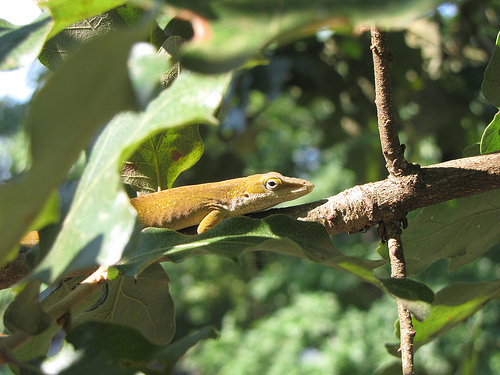

In [6]:
image

In [7]:
output = model(input_tensor)
pred_class = torch.argmax(output, dim=1).item()
print(f"Classe prédite: {pred_class}")
probs = torch.nn.functional.softmax(output, dim=1)
print(f"Probabilités: {probs[0, pred_class]}")

Classe prédite: 40
Probabilités: 0.7104200124740601


In [8]:
GMM_CONST = "GMM"
KMEANS_CONST = "KMeans"
SPECTRAL_CONST = "SpectralClustering"
AGGLOMERATIVE_CONST = "AgglomerativeClustering"
HDBSCAN_CONST = "HDBSCAN"

In [9]:
methods = {
    GMM_CONST: lambda n: GaussianMixture(n_components=n, random_state=42, covariance_type='diag', reg_covar=1e-3),
    KMEANS_CONST: lambda n: KMeans(n_clusters=n, random_state=42),
    SPECTRAL_CONST: lambda n: SpectralClustering(n_clusters=n, affinity='nearest_neighbors', random_state=42),
    AGGLOMERATIVE_CONST: lambda n: AgglomerativeClustering(n_clusters=n),
}

In [59]:
CLUSTER_FEATURE_NONE = "None"
CLUSTER_FEATURE_EYE = "Eye"
CLUSTER_FEATURE_HEAD = "Head"
CLUSTER_FEATURE_BODY = "Body"
CLUSTER_FEATURE_BEAK = "Beak"
CLUSTER_FEATURE_WING = "Wing"
CLUSTER_FEATURE_TAIL = "Tail"

In [22]:
def analysis_clusters(methods_cluster,
                      heatmaps_scaled,
                      picture_name,
                      min_cluster : int = 2,
                      max_cluster : int = 16):
    cluster_range = range(min_cluster, max_cluster)
    silhouette_scores = {method: [] for method in methods_cluster}
    GMM_dict = {}
    KMeans_dict = {}
    Spectral_dict = {}
    Agglomerative_dict = {}

    for n_clusters in cluster_range:
        print(f"Cluster numéro {n_clusters}")
        for method_name, clustering_function in methods_cluster.items():
            print(f"Analyse de {method_name}")
            model = clustering_function(n_clusters)
            labels = model.fit_predict(heatmaps_scaled)

            if len(set(labels)) > 1:
                score = silhouette_score(heatmaps_scaled, labels)
            else:
                score = -1
            silhouette_scores[method_name].append(score)

            if method_name == GMM_CONST:
                GMM_dict[n_clusters] = labels
            elif method_name == KMEANS_CONST:
                KMeans_dict[n_clusters] = labels
            elif method_name == SPECTRAL_CONST:
                Spectral_dict[n_clusters] = labels
            elif method_name == AGGLOMERATIVE_CONST:
                Agglomerative_dict[n_clusters] = labels

    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=2)
    labels_hdbscan = hdbscan_clusterer.fit_predict(heatmaps_scaled)
    hdbscan_score = silhouette_score(heatmaps_scaled, labels_hdbscan) if len(set(labels_hdbscan)) > 1 else -1
    silhouette_scores[HDBSCAN_CONST] = [hdbscan_score] * len(cluster_range)

    general_dict = {}
    general_score_dict = {}
    list_dict_keys = list(GMM_dict.keys())
    for key in list_dict_keys:
        general_dict[f"{key}_{GMM_CONST}"] = np.array(GMM_dict[key])
        general_dict[f"{key}_{KMEANS_CONST}"] = np.array(KMeans_dict[key])
        general_dict[f"{key}_{SPECTRAL_CONST}"] = np.array(Spectral_dict[key])
        general_dict[f"{key}_{AGGLOMERATIVE_CONST}"] = np.array(Agglomerative_dict[key])
        general_dict[f"{key}_{HDBSCAN_CONST}"] = np.array(labels_hdbscan)
        general_score_dict[f"{GMM_CONST}"] = np.array(silhouette_scores[GMM_CONST])
        general_score_dict[f"{KMEANS_CONST}"] = np.array(silhouette_scores[KMEANS_CONST])
        general_score_dict[f"{SPECTRAL_CONST}"] = np.array(silhouette_scores[SPECTRAL_CONST])
        general_score_dict[f"{AGGLOMERATIVE_CONST}"] = np.array(silhouette_scores[AGGLOMERATIVE_CONST])
        general_score_dict[f"{HDBSCAN_CONST}"] = np.array(silhouette_scores[HDBSCAN_CONST])

    np.savez(f"./data/clusters_v5/clusters_{picture_name}.npz", **general_dict)
    np.savez(f"./data/clusters_v5/scores_{picture_name}.npz", **general_score_dict)
    return silhouette_scores, cluster_range

In [12]:
def plot_silhouette_scores(silhouette_scores, cluster_range, file_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    for method, scores in silhouette_scores.items():
        ax.plot(cluster_range, scores, marker='o', linestyle='-', label=method)

    ax.set_xlabel("Nombre de Clusters")
    ax.set_ylabel("Silhouette Score")
    ax.set_title(f"Comparaison des Algorithmes de Clustering\n{file_name}")
    ax.legend()
    ax.grid(True)
    plt.show()

In [13]:
def list_files(directory, extension:str=".npz"):
    """Liste tous les fichiers .npz dans le dossier spécifié."""
    return [f for f in os.listdir(directory) if f.endswith(extension)]

In [14]:
def extract_picture_name(file_name):
    """Extrait picture_name d'un nom de fichier formaté comme clusters_{picture_name}.npz."""
    match = re.match(r"clusters_(.+)\.npz", file_name)
    return match.group(1) if match else None

In [15]:
def extract_code(filename: str) -> str:
    match = re.match(r"(n\d+)_", filename)
    return match.group(1) if match else ""

In [16]:
def load_and_process(file_name : str,
                     layer_name : str = "layer_40"):
    data = np.load(f"data/heatmap/{file_name}")
    heatmaps = data[layer_name]
    heatmaps = np.abs(heatmaps)
    heatmaps_flat = heatmaps.reshape(heatmaps.shape[0], -1)

    scaler = StandardScaler()
    heatmaps_scaled = scaler.fit_transform(heatmaps_flat)
    return heatmaps, heatmaps_scaled

In [77]:
def visualize_clusters(data, min_cluster, max_cluster, methods, picture_name):
    num_methods = len(methods)

    for cluster_idx, cluster_num in enumerate(range(min_cluster, max_cluster + 1)):
        fig, axes = plt.subplots(nrows=num_methods, ncols=max(4, cluster_idx + min_cluster), figsize=(16, 4 * num_methods))
        heatmaps_by_method = {}
        vmin, vmax = float("inf"), float("-inf")

        for method in methods:
            cluster_label = data[f"{cluster_num}_{method}"]
            heatmaps, _ = load_and_process(picture_name, layer_name="layer_40")
            heatmaps_by_cluster = {}

            for cluster in set(cluster_label):
                if cluster == -1:
                    continue
                indices = np.where(cluster_label == cluster)[0]
                cluster_heatmaps = heatmaps[indices]
                heatmaps_by_cluster[cluster] = cluster_heatmaps

                if cluster_heatmaps.shape[0] > 0:
                    combined_heatmap = np.sum(cluster_heatmaps, axis=0)
                    vmin = min(vmin, combined_heatmap.min())
                    vmax = max(vmax, combined_heatmap.max())

            heatmaps_by_method[method] = heatmaps_by_cluster

        for method_idx, method in enumerate(methods):
            heatmaps_by_cluster = heatmaps_by_method[method]

            for cluster, heatmaps in heatmaps_by_cluster.items():
                if heatmaps.shape[0] == 0:
                    continue
                combined_heatmap = np.sum(heatmaps, axis=0)

                ax = axes[method_idx, cluster] if num_methods > 1 else axes[cluster]
                im = ax.imshow(combined_heatmap, cmap="jet", alpha=0.7, vmin=vmin, vmax=vmax)
                ax.axis("off")
                ax.set_title(f"Cluster {cluster}\n{method}\n{heatmaps.shape[0]} éléments")

            # Ajouter la barre des couleurs dans la dernière colonne
            cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position relative de la colorbar
            fig.colorbar(im, cax=cax)

        #plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ajustement pour laisser de la place à la colorbar
        plt.show()

In [78]:
def get_feature_per_cluster(data, best_number_cluster, best_method, picture_name):
    cluster_label = data[f"{best_number_cluster}_{best_method}"]
    index_in_each_cluster = indices_par_valeur(cluster_label)
    heatmaps, _ = load_and_process(picture_name, layer_name="layer_40")
    heatmaps_by_cluster = {}
    vmin, vmax = float("inf"), float("-inf")
    for cluster in set(cluster_label):
        if cluster == -1:
            continue
        indices = np.where(cluster_label == cluster)[0]
        cluster_heatmaps = heatmaps[indices]
        heatmaps_by_cluster[cluster] = cluster_heatmaps

        if cluster_heatmaps.shape[0] > 0:
            combined_heatmap = np.sum(cluster_heatmaps, axis=0)
            vmin = min(vmin, combined_heatmap.min())
            vmax = max(vmax, combined_heatmap.max())
    return heatmaps_by_cluster, vmin, vmax, index_in_each_cluster

In [79]:
def indices_par_valeur(lst):
    arr = np.array(lst)
    return {val: np.where(arr == val)[0].tolist() for val in np.unique(arr)}

In [19]:
data = np.load("data/heatmap/n01829413_46.npz")
heatmaps_list = np.abs(data["layer_40"])

In [20]:
heatmaps_scaled = np.zeros_like(heatmaps_list)
for i in range(heatmaps_list.shape[0]):
    min_val = np.min(heatmaps_list[i])
    max_val = np.max(heatmaps_list[i])
    if max_val > min_val:  # Éviter division par zéro
        heatmaps_scaled[i] = (heatmaps_list[i] - min_val) / (max_val - min_val)
heatmaps_flat = heatmaps_scaled.reshape(heatmaps_scaled.shape[0], -1)

In [23]:
silhouette_scores, cluster_range = analysis_clusters(methods,
                                                     heatmaps_flat,
                                                     "n01829413_46",
                                                     min_cluster=2,
                                                     max_cluster=16)

Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


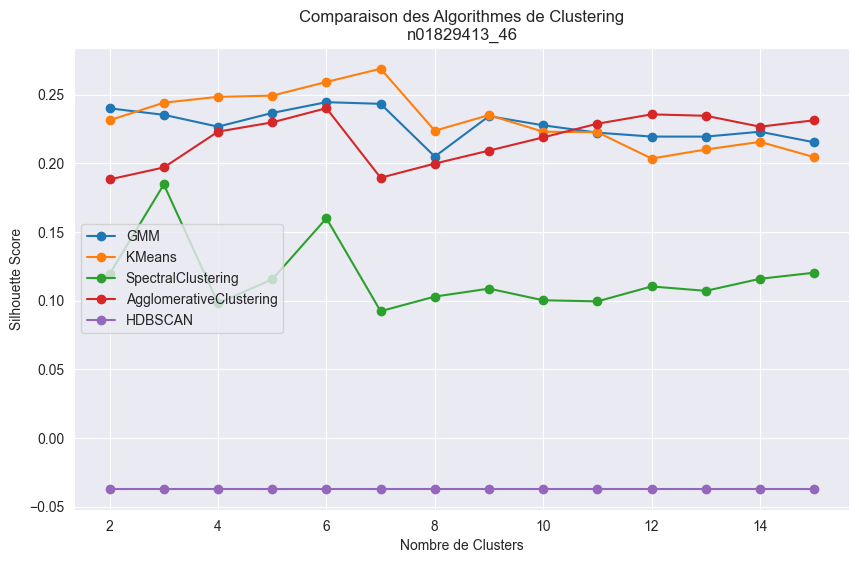

In [24]:
plot_silhouette_scores(silhouette_scores, cluster_range, "n01829413_46")

In [81]:
with open("data/imagenet_class_index_reversed.json", "r") as file:
    class_index = json.load(file)
directory_clusters = "./data/clusters_v5"  # Remplacez par votre chemin
files_clusters = list_files(directory_clusters, extension=".npz")

In [82]:
print(files_clusters)

['clusters_n01829413_46.npz', 'clusters_n01829413_5429.npz', 'scores_n01829413_46.npz', 'scores_n01829413_5429.npz']


n01829413
hornbill


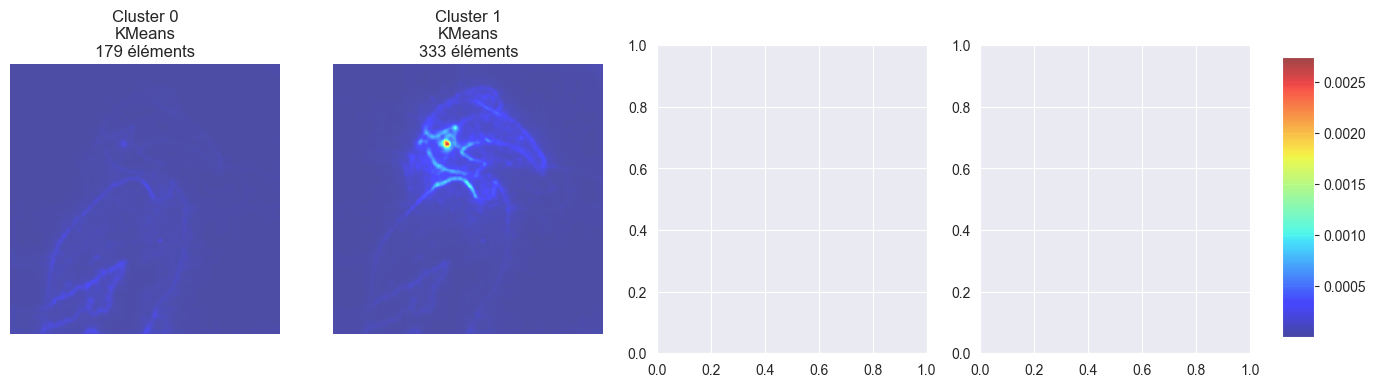

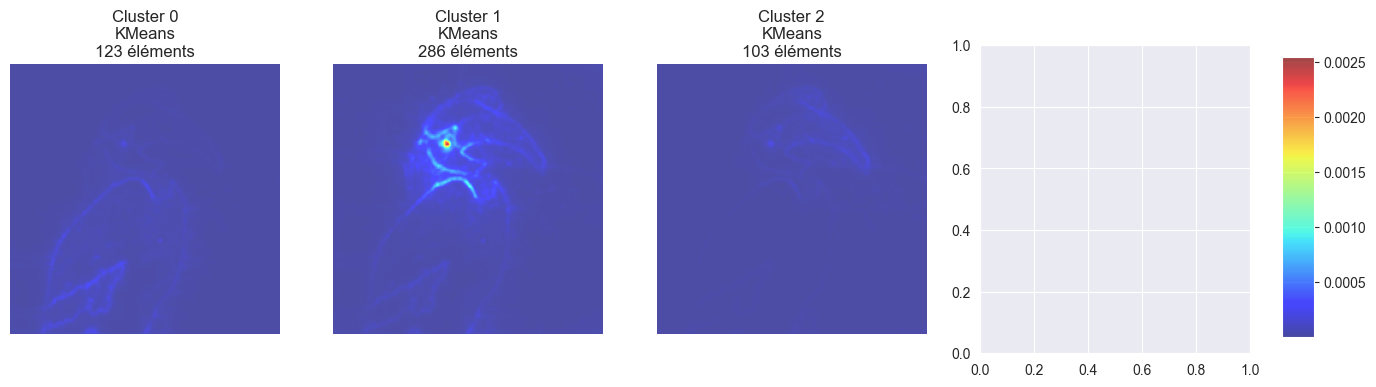

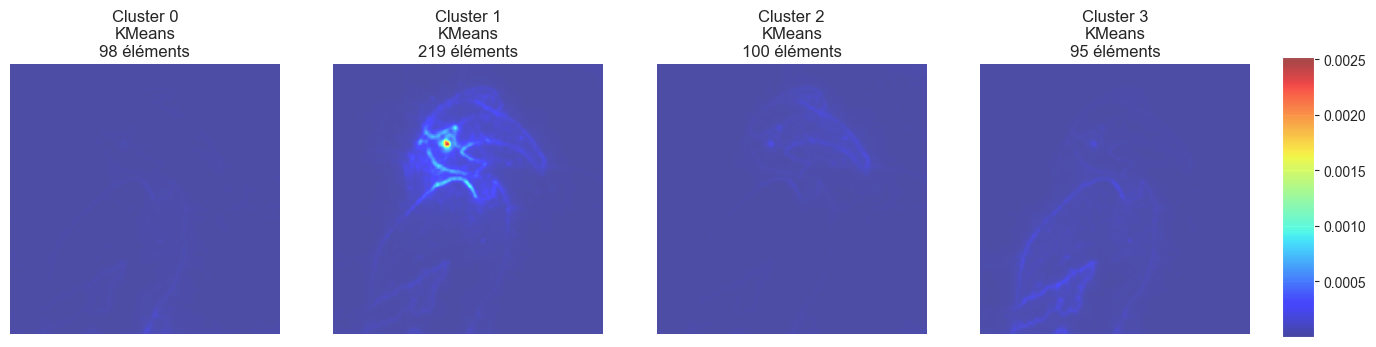

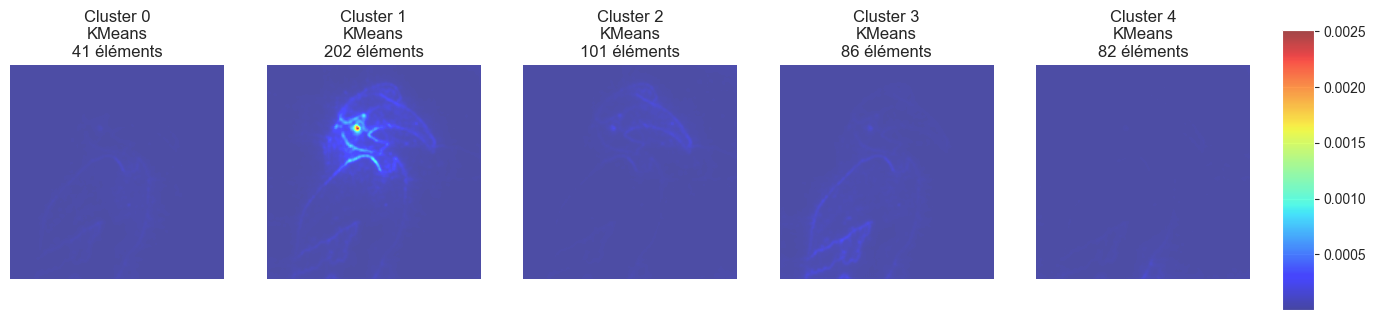

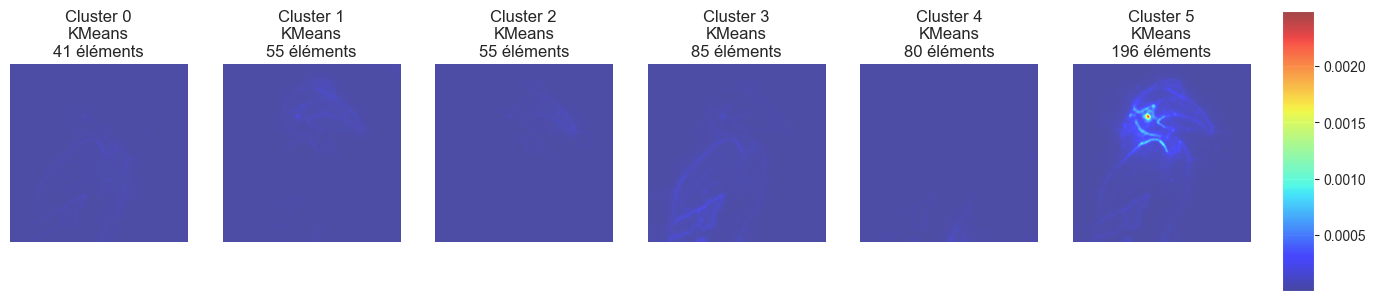

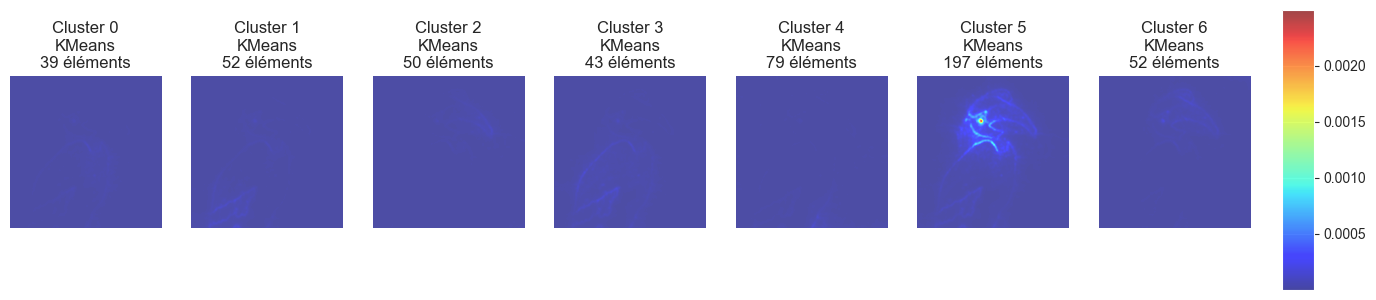

In [83]:
chosen_cluster_file_name = "clusters_n01829413_46.npz"
picture_name = extract_picture_name(chosen_cluster_file_name)
class_name = extract_code(picture_name)
picture_name_with_extension = f"{picture_name}.npz"
print(class_name)
print(class_index[class_name])
data = np.load(f"data/clusters_v5/{chosen_cluster_file_name}")
visualize_clusters(data, 2, 7, [KMEANS_CONST], picture_name_with_extension)

In [84]:
best_number_cluster = 4
best_method = KMEANS_CONST

In [85]:
heatmaps_by_cluster_1, vmin_1, vmax_1, index_in_each_cluster_1 = get_feature_per_cluster(data, best_number_cluster, best_method, picture_name_with_extension)

In [86]:
cluster_is_feature = {}
cluster_is_feature[0] = CLUSTER_FEATURE_NONE
cluster_is_feature[1] = CLUSTER_FEATURE_EYE
cluster_is_feature[2] = CLUSTER_FEATURE_BEAK
cluster_is_feature[3] = CLUSTER_FEATURE_WING

In [87]:
cluster_is_feature_by_image = {}
cluster_is_feature_by_image[picture_name] = cluster_is_feature

In [34]:
data = np.load("data/heatmap/n01829413_5429.npz")
heatmaps_list = np.abs(data["layer_40"])

In [35]:
heatmaps_scaled = np.zeros_like(heatmaps_list)
for i in range(heatmaps_list.shape[0]):
    min_val = np.min(heatmaps_list[i])
    max_val = np.max(heatmaps_list[i])
    if max_val > min_val:  # Éviter division par zéro
        heatmaps_scaled[i] = (heatmaps_list[i] - min_val) / (max_val - min_val)
heatmaps_flat = heatmaps_scaled.reshape(heatmaps_scaled.shape[0], -1)

In [37]:
silhouette_scores, cluster_range = analysis_clusters(methods,
                                                     heatmaps_flat,
                                                     "n01829413_5429",
                                                     min_cluster=2,
                                                     max_cluster=16)

Cluster numéro 2
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 3
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 4
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 5
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 6
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 7
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 8
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 9
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering
Analyse de AgglomerativeClustering
Cluster numéro 10
Analyse de GMM
Analyse de KMeans
Analyse de SpectralClustering

D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programmation\Projet\ExplicationAI\venv\PER\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


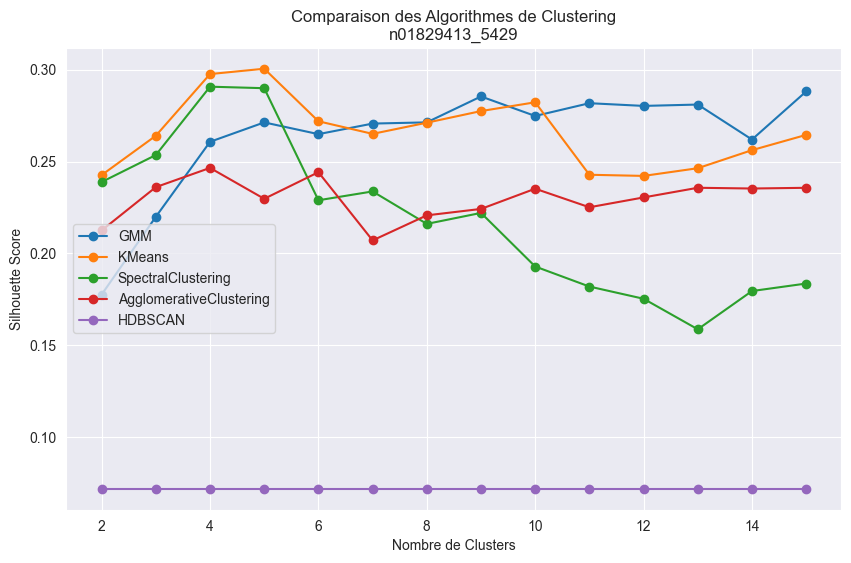

In [69]:
plot_silhouette_scores(silhouette_scores, cluster_range, "n01829413_5429")

In [89]:
with open("data/imagenet_class_index_reversed.json", "r") as file:
    class_index = json.load(file)
directory_clusters = "./data/clusters_v5"  # Remplacez par votre chemin
files_clusters = list_files(directory_clusters, extension=".npz")

In [90]:
print(files_clusters)

['clusters_n01829413_46.npz', 'clusters_n01829413_5429.npz', 'scores_n01829413_46.npz', 'scores_n01829413_5429.npz']


n01829413
hornbill


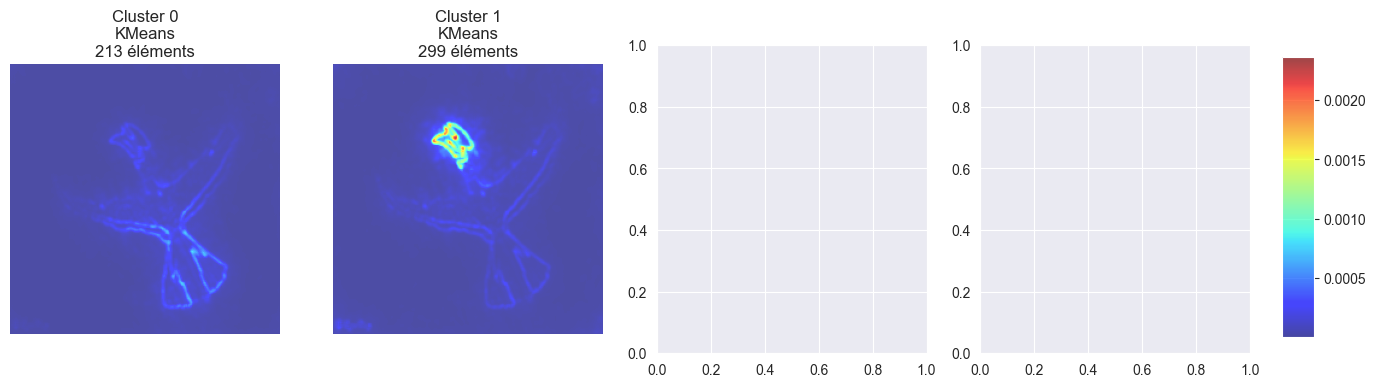

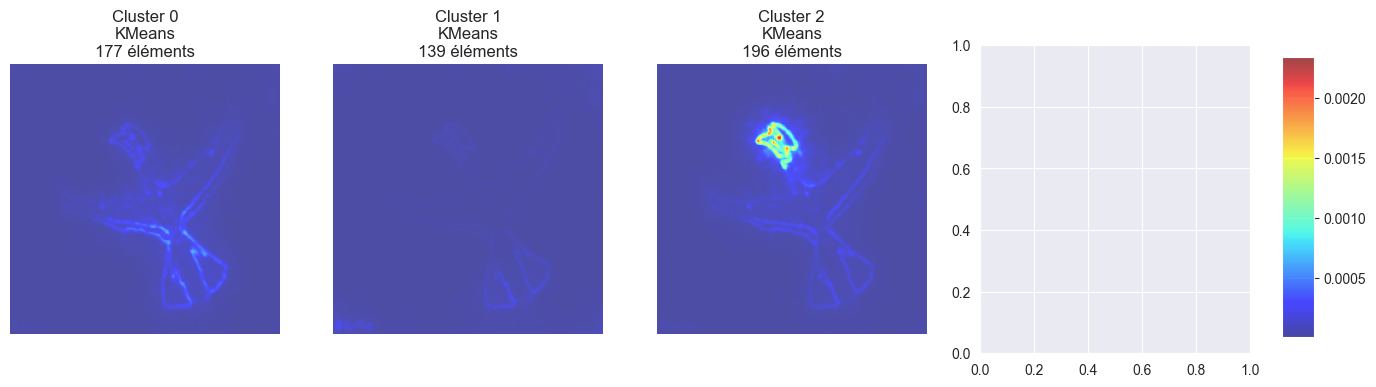

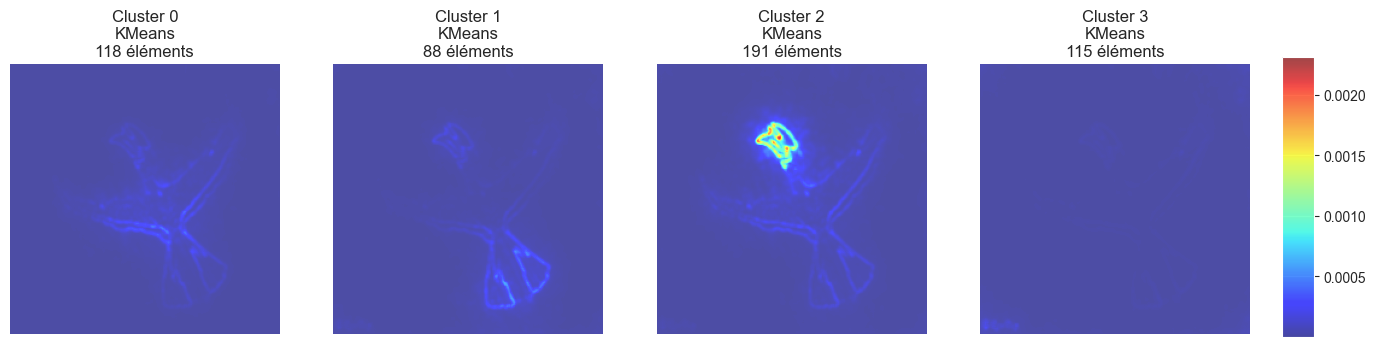

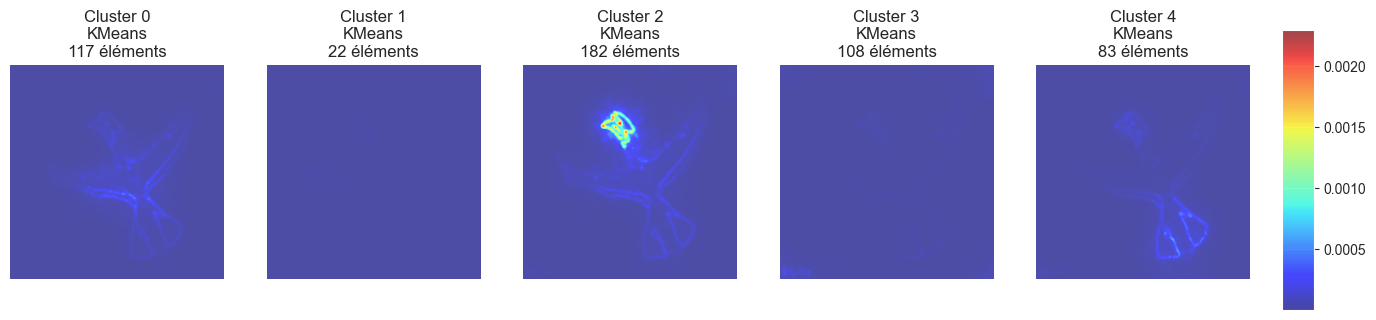

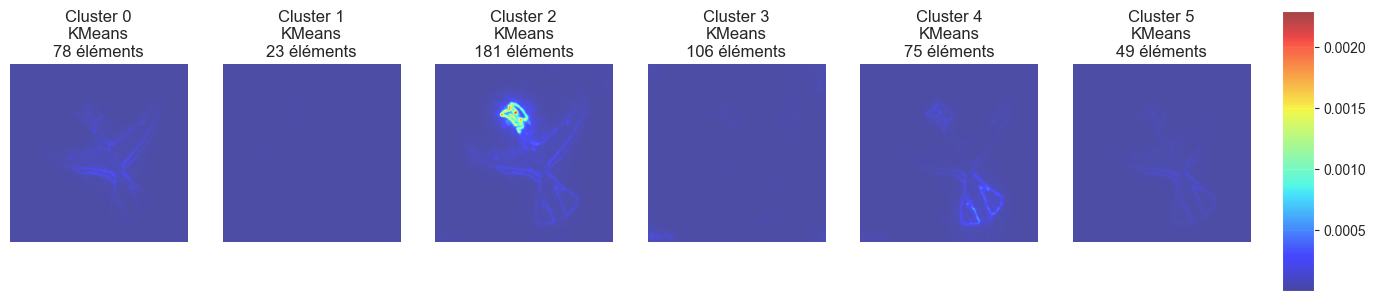

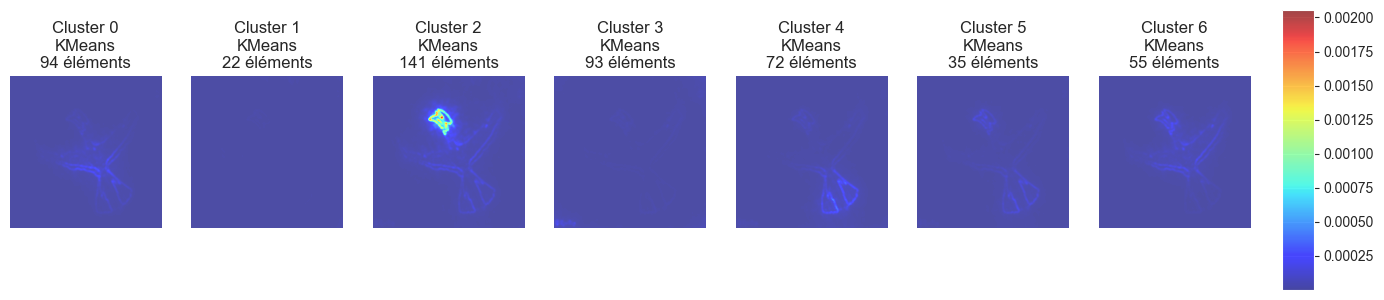

In [91]:
chosen_cluster_file_name = "clusters_n01829413_5429.npz"
picture_name = extract_picture_name(chosen_cluster_file_name)
class_name = extract_code(picture_name)
picture_name_with_extension = f"{picture_name}.npz"
print(class_name)
print(class_index[class_name])
data = np.load(f"data/clusters_v5/{chosen_cluster_file_name}")
visualize_clusters(data, 2, 7, [KMEANS_CONST], picture_name_with_extension)

In [92]:
best_number_cluster = 4
best_method = KMEANS_CONST

In [93]:
heatmaps_by_cluster_2, vmin_2, vmax_2, index_in_each_cluster_2 = get_feature_per_cluster(data, best_number_cluster, best_method, picture_name_with_extension)

In [94]:
cluster_is_feature = {}
cluster_is_feature[0] = CLUSTER_FEATURE_WING
cluster_is_feature[1] = CLUSTER_FEATURE_TAIL
cluster_is_feature[2] = CLUSTER_FEATURE_EYE
cluster_is_feature[3] = CLUSTER_FEATURE_NONE

In [95]:
cluster_is_feature_by_image[picture_name] = cluster_is_feature

In [96]:
print(cluster_is_feature_by_image)

{'n01829413_46': {0: 'None', 1: 'Eye', 2: 'Beak', 3: 'Wing'}, 'n01829413_5429': {0: 'Wing', 1: 'Tail', 2: 'Eye', 3: 'None'}}


In [112]:
all_values = []
for key, values in cluster_is_feature_by_image.items():
    for value in values.values():
        if value not in all_values:
            all_values.append(value)
print(all_values)

['None', 'Eye', 'Beak', 'Wing', 'Tail']


In [113]:
first_dict_equivalence = cluster_is_feature_by_image["n01829413_46"]
second_dict_equivalence = cluster_is_feature_by_image["n01829413_5429"]

In [176]:
couleurs = [
    "#E6194B",  # Rouge vif
    "#3CB44B",  # Vert vif
    "#FFE119",  # Jaune
    "#4363D8",  # Bleu vif
    "#F58231",  # Orange
    "#911EB4",  # Violet
    "#46F0F0",  # Cyan
    "#F032E6",  # Rose
    "#BCF60C",  # Vert clair
    "#FABEBE"   # Rose clair
]

In [107]:
def reverse_dict_list(d):
    reversed_dict = {}
    for key, values in d.items():
        for value in values:
            reversed_dict[value] = key
    return reversed_dict

In [115]:
def get_colors(n, cmap_name='tab10'):
    """
    Renvoie une liste de `n` couleurs issues d'une colormap matplotlib.

    Args:
        n (int): Nombre de couleurs désirées.
        cmap_name (str): Nom de la colormap (par défaut 'tab10', bien pour des catégories).

    Returns:
        list: Liste de couleurs utilisables dans matplotlib.
    """
    cmap = cm.get_cmap(cmap_name, n)  # Obtenir la colormap avec n couleurs distinctes
    return [cmap(i) for i in range(n)]

In [158]:
def compléter_liste(liste_courte, liste_longue):
    # Ajoute à la fin de la liste courte les éléments de la longue qui n'y sont pas
    liste_courte += [elem for elem in liste_longue if elem not in liste_courte]
    return liste_courte


In [180]:
def comparer_dictionnaires(dict1, dict2, dict_equivalence1, dict_equivalence2, all_values, list_colors : list = None):
    if list_colors is None:
        list_colors = get_colors(len(dict2))

    # Inversion du dictionnaire pour obtenir la correspondance index -> classe dict1
    reversed_dict_1 = reverse_dict_list(dict1)

    # Initialisation : chaque classe de all_values est une clé, avec une liste de zéros de longueur égale au nombre de classes de dict2
    global_dict = {class_name: [0] * len(dict2) for class_name in all_values}

    # Liste des classes provenant de dict2 (ordonnée selon les clés de dict2)
    class_names_dict2 = [dict_equivalence2[key] for key in dict2.keys()]

    # Remplissage de global_dict avec les correspondances entre dict1 et dict2
    for i, (key2, indices) in enumerate(dict2.items()):
        for index in indices:
            class_name_dict1 = dict_equivalence1.get(reversed_dict_1.get(index))
            if class_name_dict1:
                global_dict[class_name_dict1][i] += 1

    # Axe x : classes de dict1
    x = range(len(all_values))

    # Création des barres empilées
    bottom = [0] * len(all_values)
    for i, (key2, color) in enumerate(zip(dict2.keys(), list_colors)):
        values = [global_dict[class_name][i] for class_name in all_values]
        plt.bar(x, values, bottom=bottom, label=dict_equivalence2[key2], color=color)
        bottom = [b + v for b, v in zip(bottom, values)]

    # Paramétrage du graphique
    plt.xticks(x, all_values, rotation=45)
    plt.xlabel("Classes de dict1")
    plt.ylabel("Nombre d'éléments")
    plt.title("Comparaison des classes entre dict1 et dict2 (barres empilées)")
    plt.legend(title="Classes de dict2")
    plt.tight_layout()

    # Affichage du graphique
    plt.show()


In [182]:
def comparer_dictionnaires(dict1, dict2, dict_equivalence1, dict_equivalence2, all_values, list_colors=None):
    if list_colors is None:
        list_colors = get_colors(len(dict2))

    reversed_dict_1 = reverse_dict_list(dict1)
    global_dict = {class_name: [0] * len(dict2) for class_name in all_values}
    class_names_dict2 = [dict_equivalence2[key] for key in dict2.keys()]

    for i, (key2, indices) in enumerate(dict2.items()):
        for index in indices:
            class_name_dict1 = dict_equivalence1.get(reversed_dict_1.get(index))
            if class_name_dict1:
                global_dict[class_name_dict1][i] += 1

    x = range(len(all_values))
    bottom = [0] * len(all_values)

    for i, (key2, color) in enumerate(zip(dict2.keys(), list_colors)):
        values = [global_dict[class_name][i] for class_name in all_values]
        bars = plt.bar(x, values, bottom=bottom, label=dict_equivalence2[key2], color=color)

        # Affichage des valeurs dans chaque sous-partie de la barre
        for bar, value in zip(bars, values):
            if value > 0:
                plt.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                         str(value), ha='center', va='center', fontsize=9, color='black')

        bottom = [b + v for b, v in zip(bottom, values)]

    # Affichage du total au sommet de chaque barre
    for i, total in enumerate(bottom):
        if total > 0:
            plt.text(i, total, str(total), ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.xticks(x, all_values, rotation=45)
    plt.xlabel("Classes de dict1")
    plt.ylabel("Nombre d'éléments")
    plt.title("Comparaison des classes entre dict1 et dict2 (barres empilées)")
    plt.legend(title="Classes de dict2")
    plt.tight_layout()
    plt.show()

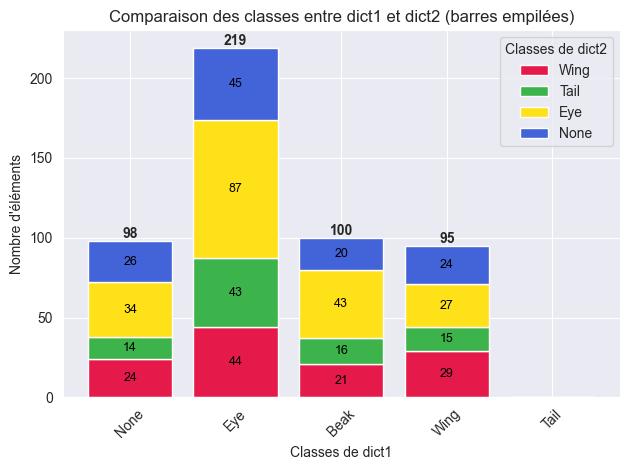

In [183]:
comparer_dictionnaires(index_in_each_cluster_1, index_in_each_cluster_2, first_dict_equivalence, second_dict_equivalence, all_values, couleurs)